# Pipelines, Imbalanced Data and AutoML
In this notebook, we are going see some examples on how to use Panda Pipes and Scikit learn's pipelines. Then, we check some of the strategies to deal with imabalanced data. Finally, we check some AutoML tools to help us save time on model selection and tuning.

##About the Dataset
The dataset we work with in this assignment is orders of **Ubaar** platform. Ubaar is an iranian truck renting plarform. [Here](https://ubaar.ir/) you can visit their platform

In [ ]:
#@title Setup Environment
import sklearn
import pandas as pd
import io
import os
import copy
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
%matplotlib inline
sns.set(color_codes=True)

from google.colab import drive
from tqdm.notebook import trange, tqdm
from IPython.display import clear_output

clear_output()
print("Done!")

Done!


In [ ]:
!pip install xgboost==1.2.0

clear_output()
print("Done!")

Done!


## Loading the Dataset

Now we will load orders dataset from personal google drive. So we must mount the drive and load the dataset from appropriate path.

In [ ]:
#@title Connect to Google Drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data():
  file_path = '/content/drive/MyDrive/Datasets/Ubaar/orders_data.csv'
  return pd.read_csv(file_path)

In [ ]:
file_path = '/content/drive/MyDrive/Datasets/Ubaar/orders_data.csv'
orders_data = load_data()
print("Orders Dataset Shape: ", orders_data.shape)

Orders Dataset Shape:  (44052, 30)


## Getting Some Insights from Our Data

Since a good visualization helps a lot in making sense of our data, we will draw some charts to get better insight about the Ubaar orders dataset. Also we will take a brief look at the dataset

In [ ]:
orders_data.head(10)

,Load Type,Source City,Destination City,Source State,Destination State,Source Region,Destination Region,Who Added Role,Driver Income,Weight,...,Destination Lat,Destination Lng,Dispatch Time Delta,Pickup Date Time Delta,Order Channel,Packaging Type,Creation Datetime,Unload Option,Has Comments,Load Status
0,بار صنعتی,یزد,بندرعباس,یزد,هرمزگان,یزد,بندرعباس,anonymous,0.0,24.0,...,27.183222,56.266646,23.928889,NaN,NaN,hichkodam,2019-11-05 06:46:15.847289+00:00,NaN,0,reject_price
1,بار صنعتی,قزوین,رودسر,قزوین,گیلان,قزوین,چابکسر,anonymous,0.0,5.0,...,36.980067,50.531772,23.970278,NaN,NaN,hichkodam,2019-11-05 20:01:46.763769+00:00,NaN,0,reject_price
2,بار صنعتی,تهران,همدان,تهران,همدان,تهران,همدان,anonymous,0.0,2.0,...,34.798857,48.515023,23.962778,NaN,NaN,hichkodam,2019-11-06 09:13:13.686217+00:00,NaN,0,reject_price
3,بار صنعتی,آمل,گرگان,مازندران,گلستان,آمل,گرگان,anonymous,0.0,15.0,...,36.845643,54.439336,23.974722,NaN,NaN,hichkodam,2019-10-31 09:52:30.930302+00:00,NaN,0,reject_price
4,گلدان پلاستیکی,هشتگرد,اردبیل,البرز,اردبیل,پل کردان,اردبیل,baarbari,0.0,2.0,...,38.256645,48.317509,16.749444,68.358889,web,karton,2019-11-20 13:45:01.859383+00:00,day,0,delivered
5,بار صنعتی,کازرون,تهران,فارس,تهران,قیروکازین,تهران,anonymous,0.0,5.0,...,35.688905,51.388435,23.968056,NaN,NaN,hichkodam,2019-10-31 04:34:54.206605+00:00,NaN,0,reject_price
6,بار صنعتی,خوانسار,دیلم,اصفهان,بوشهر,خوانسار,بندر دیلم,anonymous,0.0,10.0,...,30.058981,50.167812,23.978889,NaN,NaN,hichkodam,2019-11-02 19:46:15.870573+00:00,NaN,0,reject_price
7,بار صنعتی,اصفهان,گنبد کاووس,اصفهان,گلستان,اصفهان,گنبد کاووس,anonymous,0.0,5.0,...,37.238322,55.167322,23.943889,NaN,NaN,hichkodam,2019-11-03 05:16:21.270880+00:00,NaN,0,reject_price
8,انواع رنگ ومواد پاك کننده,اشتهارد,مشهد,البرز,خراسان رضوی,شهرک صنعتی اشتهارد,مشهد,baarbari,1100000.0,4.0,...,36.272622,59.600624,0.403056,NaN,android,falleh,2019-10-15 07:35:48.686186+00:00,day,0,cancelled
9,انواع سموم وکودشیمیایی,تهران,اراک,تهران,مرکزی,تهران,اراک,user,744000.0,15.0,...,34.095355,49.701349,39.288611,NaN,android,kiseh_gooni,2019-10-24 13:12:40.461622+00:00,day,1,cancelled


In [ ]:
orders_data.describe()

,Driver Income,Weight,Distance,Duration,Transport Cost,Source Lat,Source Lng,Destination Lat,Destination Lng,Dispatch Time Delta,Pickup Date Time Delta,Has Comments
count,4.405200e+04,44052.000000,44052.000000,44052.000000,4.405200e+04,44052.000000,44052.000000,44052.000000,44052.000000,44052.000000,2808.000000,44052.000000
mean,3.677479e+11,7.860764,486.471045,5.681138,3.677479e+11,34.751266,51.545719,34.018325,51.926935,28.755725,27.093312,0.362458
std,7.718487e+13,7.912958,440.643799,4.893344,7.718487e+13,2.201000,2.750519,3.039853,3.837871,59.757645,22.847216,0.480716
min,0.000000e+00,0.020000,0.000000,0.000000,0.000000e+00,24.494214,28.953026,24.494214,28.953026,-4.676944,0.006667,0.000000
25%,0.000000e+00,2.000000,50.000000,1.000000,0.000000e+00,33.640419,50.681933,32.198349,49.587414,3.048333,17.518611,0.000000
50%,1.800000e+05,4.000000,442.701000,4.861806,1.850000e+05,35.688905,51.388435,35.490586,51.388435,18.008333,21.120972,0.000000
75%,1.000000e+06,11.000000,817.966000,9.536319,1.000000e+06,35.837669,51.667983,36.271035,53.031317,24.240069,29.626528,1.000000
max,1.620000e+16,25.000000,2622.035000,28.618889,1.620000e+16,41.052112,69.870829,41.052112,69.870829,2204.550833,481.925000,1.000000


In [ ]:
orders_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44052 entries, 0 to 44051
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Load Type               44052 non-null  object 
 1   Source City             44052 non-null  object 
 2   Destination City        44052 non-null  object 
 3   Source State            44052 non-null  object 
 4   Destination State       44052 non-null  object 
 5   Source Region           44052 non-null  object 
 6   Destination Region      44052 non-null  object 
 7   Who Added Role          44052 non-null  object 
 8   Driver Income           44052 non-null  float64
 9   Weight                  44052 non-null  float64
 10  Distance                44052 non-null  float64
 11  Duration                44052 non-null  float64
 12  Vehicle Type            44052 non-null  object 
 13  Vehicle Options         44052 non-null  object 
 14  Baarnameh Type          38366 non-null

It is now time to do some EDA! We just play with different data columns to get more sense about our data.

Finally, let's check the distribution of packaging types

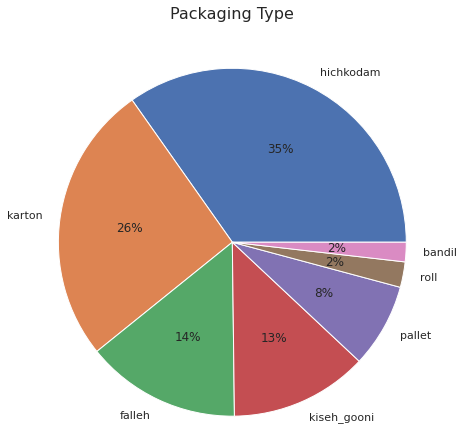

In [ ]:
orders_data['Packaging Type'].value_counts().plot.pie(autopct='%1.0f%%',radius=2,ylabel='')
plt.title('Packaging Type', y=1.5,fontsize=16)
plt.show()

In [ ]:
print('Total number of unique positions: %d' %len(orders_data['Packaging Type'].unique()))

Total number of unique positions: 7


##Panda Pipes

In the previous assignments notebook, we performed everything in code blocks. Now let's see how we can achieve the same with panda pipes

Now let's define some functions, and join them to build a pipeline.

In [ ]:
#@title Reformat Date and Time Columns Utilities
def reformat_date(date):
  return date.replace("-", '')

def reformat_time(time):
  time = time.replace(":", '')
  return time[:-2]

def reformat_datetime(datetime):
  return datetime[:datetime.find('.')]

def extract_date(datetime):
  return datetime[:datetime.find(' ')]

def extract_time(datetime):
  return datetime[datetime.find(' '):]

def extract_day(date):
  return int(date[-2:])

def extract_month(date):
  return int(date[-4:-2])

def extract_year(date):
  return int(date[:4])

def extract_hour(time):
  return int(time[:-2])

def extract_mins(time):
  return int(time[-2:])

In [ ]:
def reformat_date_times(input_df):
  input_df['Dispatch Date'] = input_df['Dispatch Date'].apply(reformat_date)
  input_df['Dipatch Time'] = input_df['Dipatch Time'].apply(reformat_time)

  input_df['Creation Datetime'] = input_df['Creation Datetime'].apply(reformat_datetime)

  input_df['Creation Date'] = input_df['Creation Datetime'].apply(extract_date)
  input_df['Creation Time'] = input_df['Creation Datetime'].apply(extract_time)
  input_df['Creation Date'] = input_df['Creation Date'].apply(reformat_date)
  input_df['Creation Time'] = input_df['Creation Time'].apply(reformat_time)

  input_df['Dispatch Month'] = input_df['Dispatch Date'].apply(extract_month)
  input_df['Dispatch Day'] = input_df['Dispatch Date'].apply(extract_day)
  input_df['Creation Month'] = input_df['Creation Date'].apply(extract_month)
  input_df['Creation Day'] = input_df['Creation Date'].apply(extract_day)

  input_df['Dispatch Hour'] = input_df['Dipatch Time'].apply(extract_hour)
  input_df['Dispatch Minuts'] = input_df['Dipatch Time'].apply(extract_mins)
  input_df['Creation Hour'] = input_df['Creation Time'].apply(extract_hour)
  input_df['Creation Minuts'] = input_df['Creation Time'].apply(extract_mins)

  to_drop_columns = ['Dispatch Date','Dipatch Time', 'Creation Datetime', 'Creation Date', 'Creation Time']
  input_df.drop(to_drop_columns, axis=1, inplace=True)
  return input_df


In [ ]:
def fill_categorical_nulls(input_df):
  input_df['Order Channel'] = input_df['Order Channel'].fillna('Unknown')
  input_df['Baarnameh Type'] = input_df['Baarnameh Type'].fillna('Unknown')
  input_df['Unload Option'] = input_df['Unload Option'].fillna('Not_Have')
  input_df['Pickup Date Time Delta'] = input_df['Pickup Date Time Delta'].fillna(0)
  return input_df

In [ ]:
from sklearn import preprocessing

def encode_categorical_data(input_df):
  input_df['vehicle_typ_enc'] = input_df['Vehicle Type'].astype('category').cat.codes
  input_df['baarnameh_typ_enc'] = input_df['Baarnameh Type'].astype('category').cat.codes
  input_df['order_channel_enc'] = input_df['Order Channel'].astype('category').cat.codes
  input_df['unload_option_enc'] = input_df['Unload Option'].astype('category').cat.codes
  input_df['who_added_role_enc'] = input_df['Who Added Role'].astype('category').cat.codes
  input_df['load_type_enc'] = input_df['Load Type'].astype('category').cat.codes

  le = preprocessing.LabelEncoder()
  le.fit(input_df['Destination State'])

  input_df['source_state_enc'] = le.transform(input_df['Source State'])
  input_df['dest_state_enc'] = le.transform(input_df['Destination State'])

  return input_df

In [ ]:
def drop_unnecessary_columns(input_df, cols_list):
  to_drop_columns = cols_list
  try:
    input_df.drop(to_drop_columns, axis=1, inplace=True)
  except:
    pass
  return input_df

In [ ]:
def load_type_threshold(input_df, threshold_num):
  freq = input_df['Load Type'].value_counts()
  idx = freq.values
  print("Number of unique Load Type values: ",len(freq[freq.values > threshold_num]))
  print("From raw dataset {0:.2f} will remains after using the above threshold".format(
      (freq[freq.values > threshold_num].sum())/input_df.shape[0]*100)
    )
  freq_ser = freq[freq.values > threshold_num]
  input_df = input_df[input_df['Load Type'].isin(freq_ser.index)]
  return input_df

In [ ]:
to_drop_columns = ['Vehicle Options','Source City', 'Destination City', 'Source State', 'Destination State', 'Source Region', 'Destination Region', 'Has Comments', 'Vehicle Type', 'Baarnameh Type', 'Order Channel', 'Unload Option', 'Who Added Role', 'Load Status', 'Load Type']
limit_threshold = 20
proc_orders = (load_data()
                .pipe(reformat_date_times)
                .pipe(fill_categorical_nulls)
                .pipe(load_type_threshold, limit_threshold)
                .pipe(encode_categorical_data)
                .pipe(drop_unnecessary_columns, to_drop_columns)
                )

Number of unique Load Type values:  128
From raw dataset 90.94 will remains after using the above threshold


In [ ]:
proc_orders.shape

(40062, 28)

In [ ]:
proc_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40062 entries, 0 to 44051
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Driver Income           40062 non-null  float64
 1   Weight                  40062 non-null  float64
 2   Distance                40062 non-null  float64
 3   Duration                40062 non-null  float64
 4   Transport Cost          40062 non-null  float64
 5   Source Lat              40062 non-null  float64
 6   Source Lng              40062 non-null  float64
 7   Destination Lat         40062 non-null  float64
 8   Destination Lng         40062 non-null  float64
 9   Dispatch Time Delta     40062 non-null  float64
 10  Pickup Date Time Delta  40062 non-null  float64
 11  Packaging Type          40062 non-null  object 
 12  Dispatch Month          40062 non-null  int64  
 13  Dispatch Day            40062 non-null  int64  
 14  Creation Month          40062 non-null

### Split Train and Test Sets

By now, we have a clean dataset. Now let's separate the train and test sets, then we can apply preprocessing on the training set.

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
y = proc_orders.pop('Packaging Type')

X_train, X_test, y_train, y_test = train_test_split(proc_orders,y,test_size=0.2)
print(X_train.shape)
print(X_test.shape)

(32049, 27)
(8013, 27)


In [ ]:
proc_orders.head(5)

,Driver Income,Weight,Distance,Duration,Transport Cost,Source Lat,Source Lng,Destination Lat,Destination Lng,Dispatch Time Delta,...,Creation Hour,Creation Minuts,vehicle_typ_enc,baarnameh_typ_enc,order_channel_enc,unload_option_enc,who_added_role_enc,load_type_enc,source_state_enc,dest_state_enc
0,0.0,24.0,658.672,7.296944,0.0,31.899421,54.360979,27.183222,56.266646,23.928889,...,6,46,4,0,0,0,1,24,35,24
1,0.0,5.0,0.000,0.000000,0.0,36.271035,50.012455,36.980067,50.531772,23.970278,...,20,1,1,0,0,0,1,24,19,34
2,0.0,2.0,319.570,3.578056,0.0,35.688905,51.388435,34.798857,48.515023,23.962778,...,9,13,2,0,0,0,1,24,8,25
3,0.0,15.0,206.191,2.859444,0.0,36.467626,52.350694,36.845643,54.439336,23.974722,...,9,52,0,0,0,0,1,24,22,33
5,0.0,5.0,1146.483,12.883611,0.0,28.355906,52.959966,35.688905,51.388435,23.968056,...,4,34,1,0,0,0,1,24,18,8


## Sklearn Piplines

So far, we have seen how we can use Pandas pipes to simplify our code and make it more reusable. In the same spirit, we can use Scikit-learn's pipelines to simplify the code for preprocessing and training our algorithm.


To demonstrate how we can use sklearn's pipelines, we start by normalizing all the columns so that they have a "similar" range. To this end, we will use scikit-learn's SatndardScaler and MinMaxScaler.

### Preprocessing: Normalization/Stadardization



In [ ]:
from sklearn.pipeline import Pipeline

First, let's define a *transformer*, for SatandardScaler.

In [ ]:
standard_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),    # The imputer is of no use for our dataset, but could be handy in real life
    ('standard_scaler', StandardScaler())])

Let's define another *transformer*, for MinMaxScaler.

In [ ]:
minmax_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('minmax_scaler', MinMaxScaler())])

Now let's put them together

In [ ]:
standard_scale_columns = ['Driver Income','Weight','Distance','Duration','Transport Cost']
minmax_scale_columns = list(set(proc_orders.columns)-set(standard_scale_columns))

In [ ]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('satandard', standard_transformer, standard_scale_columns),
        ('minmax', minmax_transformer, minmax_scale_columns)])

### Classification

Now that our data is ready, it is time to test classification algorithms in action. We will use XGBoost as an example.

In [ ]:
from xgboost import XGBClassifier

We can attach the model to the pipeline too. To make whole process as smooth as possible.

In [ ]:
complete_model = Pipeline(steps=[
                      ('preprocessor', preprocessor),
                      ('classifier', XGBClassifier(n_estimators=50,max_depth=10,eta=0.1,subsample=0.8))])

Now all we need to do, is to fit the model on the training set.

Note that this command not only performs the training of the ML algorithm, but also **handles preprocessing steps** before that.

In [ ]:
complete_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('satandard',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Driver Income', 'Weight',
                                                   'Distance', 'Duration',
                                                   'Transport Cost']),
                                                 ('minmax',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmax_scaler',
  

### Results

Now, we will see the F1 score and confusion matrix for this classification

In [ ]:
predictions = complete_model.predict(X_test)
print('Macro F1-score is %.3f' %f1_score(y_test, predictions, average='macro'))

Macro F1-score is 0.861


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


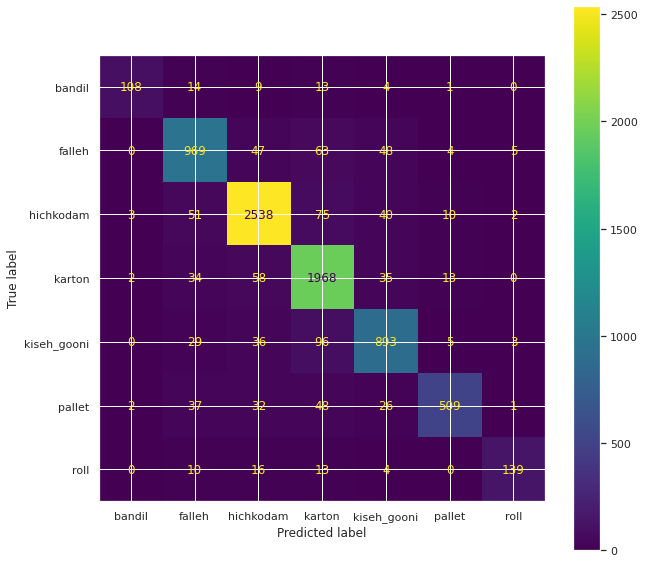

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(complete_model, X_test, y_test,ax=ax)
plt.show()

## Imbalanced Data

Some of the classes in our dataset were hugely imbalanced (e.g. bandil, roll, kartoon). Let's see some strategies to alleviate the situation. We are going to use pyton's imblearn library. First we will use undersampling startegies and then oversampling and finally, we use SMOTE oversampling to perform a better oversampling. We train the classifer each time and compare the results.

Let's see Packaging Type distribution again.

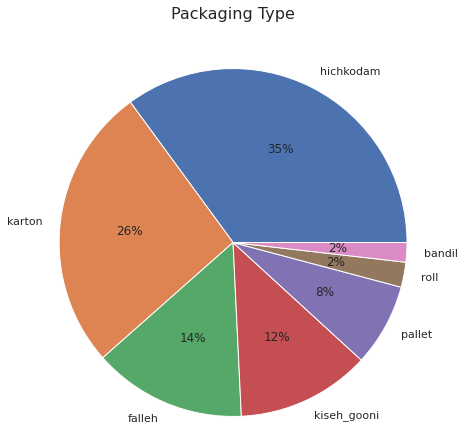

In [ ]:
y_train.value_counts().plot.pie(autopct='%1.0f%%',radius=2,ylabel='')
plt.title('Packaging Type', y=1.5,fontsize=16)
plt.show()

### Undersampling
There are multiple undersapling startegies:

* float (only available for binary classification): the desired ratio of the number of samples in the minority class over the number of samples in the majority class after resampling
* 'majority': resample only the majority class;
* 'not minority': resample all classes but the minority class;
* 'not majority': resample all classes but the majority class;
* 'all': resample all classes;
* 'auto': equivalent to 'not minority'.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='not minority')

In [ ]:
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

Let's take a look at the new distribution:

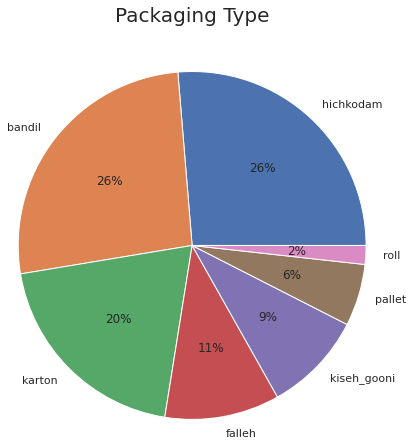

In [ ]:
y_resampled.value_counts()[0:10].plot.pie(autopct='%1.0f%%',radius=2,ylabel='')
plt.title('Packaging Type', y=1.5,fontsize=20)
plt.show()

Pretty neat! But we have lost quite a lot of data:

In [ ]:
y_resampled.shape

(4060,)

In [ ]:
print("We lost about {} of clean data".format(1-(y_resampled.shape[0]/X_test.shape[0])))

We lost about 0.4933233495569699 of clean data


In [ ]:
from imblearn.pipeline import make_pipeline as imb_make_pipeline

In [ ]:
new_pipeline = imb_make_pipeline(
    ColumnTransformer(transformers=[
        ('satandard', StandardScaler(), standard_scale_columns),
        ('minmax', MinMaxScaler(), minmax_scale_columns)]),
    XGBClassifier(n_estimators=50,max_depth=10,eta=0.1,subsample=0.8),
)


In [ ]:
new_pipeline.steps.insert(-1,('sampling',RandomUnderSampler(sampling_strategy='not minority'),)) # Step as one step before the last

In [ ]:
new_pipeline.steps

[('columntransformer',
  ColumnTransformer(transformers=[('satandard', StandardScaler(),
                                   ['Driver Income', 'Weight', 'Distance',
                                    'Duration', 'Transport Cost']),
                                  ('minmax', MinMaxScaler(),
                                   ['Dispatch Day', 'Destination Lng',
                                    'Source Lng', 'Destination Lat',
                                    'load_type_enc', 'who_added_role_enc',
                                    'order_channel_enc', 'Dispatch Time Delta',
                                    'Creation Hour', 'Creation Minuts',
                                    'Creation Month', 'baarnameh_typ_enc',
                                    'Creation Day', 'Dispatch Hour',
                                    'Dispatch Minuts', 'source_state_enc',
                                    'dest_state_enc', 'Dispatch Month',
                                    'unload_optio

In [ ]:
new_pipeline.fit(X_train, y_train)
predictions = new_pipeline.predict(X_test)
print('Macro F1-score is %.3f' %f1_score(y_test, predictions, average='macro'))

Macro F1-score is 0.651


The score is not so good, which is not totally unexpected, as we have thrown away a lot of our data!

### RandomOversampling
So let's try oversampling instead of undersampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy='minority')

In [ ]:
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

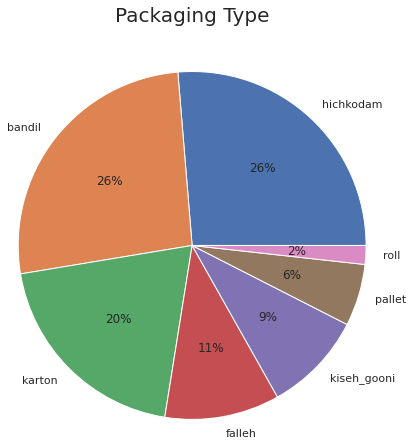

In [ ]:
y_resampled.value_counts()[0:10].plot.pie(autopct='%1.0f%%',radius=2,ylabel='')
plt.title('Packaging Type', y=1.5,fontsize=20)
plt.show()

Note that the above strategy has over-sample only the minority class, which works fine in binary classification.

But since we have multiple under-represented classes, we need to do this step for those too. To this end, we can use a different oversampling strategy and pass a dictionary, with the desired number of samples in the minority classes:

In [ ]:
sum(y_train=='falleh')

4561

In [ ]:
# The numbers are the desired number of samples, after oversmapling
sampling_dict = {'roll':2000,'pallet':4000,'kiseh_gooni':5000, 'bandil': 2000, 'falleh': 5000, 'kiseh_gooni': 4500}

In [ ]:
ros = RandomOverSampler(sampling_strategy=sampling_dict)

In [ ]:
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

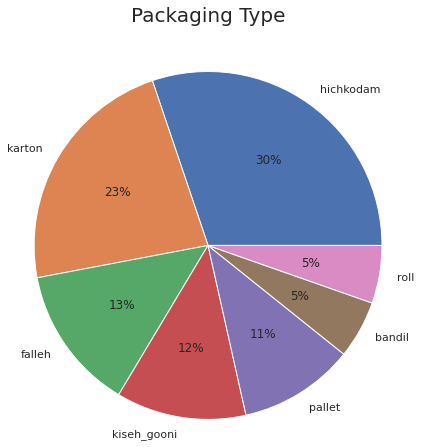

In [ ]:
y_resampled.value_counts()[0:10].plot.pie(autopct='%1.0f%%',radius=2,ylabel='')
plt.title('Packaging Type', y=1.5,fontsize=20)
plt.show()

Looks better! We could have also integrated these steps in the pipelines.

In [ ]:
# First let's pop the undersampler out
new_pipeline.steps.pop(-2)
new_pipeline.steps.insert(-1,('over_sampling',RandomOverSampler(sampling_strategy=sampling_dict),))
new_pipeline.steps

[('columntransformer',
  ColumnTransformer(transformers=[('satandard', StandardScaler(),
                                   ['Driver Income', 'Weight', 'Distance',
                                    'Duration', 'Transport Cost']),
                                  ('minmax', MinMaxScaler(),
                                   ['Dispatch Day', 'Destination Lng',
                                    'Source Lng', 'Destination Lat',
                                    'load_type_enc', 'who_added_role_enc',
                                    'order_channel_enc', 'Dispatch Time Delta',
                                    'Creation Hour', 'Creation Minuts',
                                    'Creation Month', 'baarnameh_typ_enc',
                                    'Creation Day', 'Dispatch Hour',
                                    'Dispatch Minuts', 'source_state_enc',
                                    'dest_state_enc', 'Dispatch Month',
                                    'unload_optio

In [ ]:
new_pipeline.fit(X_train, y_train)
predictions = new_pipeline.predict(X_test)
print('Macro F1-score is %.3f' %f1_score(y_test, predictions, average='macro'))

Macro F1-score is 0.874


The score is improved quite nicely, Hooray! Let's see if we can improve it even further.

### SMOTE: Synthetic Minority Over-sampling Technique.
SMOTE is a technique to *artificially create* new samples for the under-represented classes. It was introduced in 2011 and here is the [link to the paper](https://arxiv.org/abs/1106.1813) that mentioned this idea.


In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=sampling_dict)

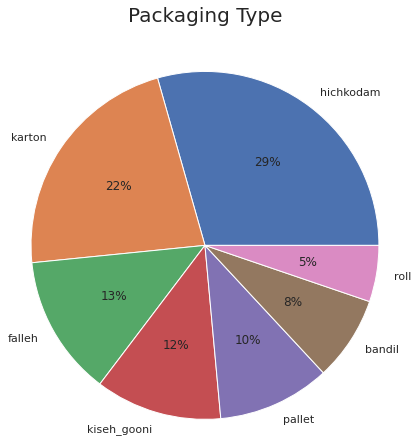

In [ ]:
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
y_resampled.value_counts()[0:10].plot.pie(autopct='%1.0f%%',radius=2,ylabel='')
plt.title('Packaging Type', y=1.5,fontsize=20)
plt.show()

The end result looks the same (obviously!). Let's see if this strategy has an effect on the performance.

In [ ]:
# First let's pop the last oversampling layer out
new_pipeline.steps.pop(-2)
new_pipeline.steps.insert(-1,('over_sampling',SMOTE(sampling_strategy={'roll':2000,'pallet':4000,'kiseh_gooni':5000, 'bandil': 2000, 'falleh': 5000, 'kiseh_gooni': 4500}),))
new_pipeline.steps

[('columntransformer',
  ColumnTransformer(transformers=[('satandard', StandardScaler(),
                                   ['Driver Income', 'Weight', 'Distance',
                                    'Duration', 'Transport Cost']),
                                  ('minmax', MinMaxScaler(),
                                   ['Dispatch Day', 'Destination Lng',
                                    'Source Lng', 'Destination Lat',
                                    'load_type_enc', 'who_added_role_enc',
                                    'order_channel_enc', 'Dispatch Time Delta',
                                    'Creation Hour', 'Creation Minuts',
                                    'Creation Month', 'baarnameh_typ_enc',
                                    'Creation Day', 'Dispatch Hour',
                                    'Dispatch Minuts', 'source_state_enc',
                                    'dest_state_enc', 'Dispatch Month',
                                    'unload_optio

In [ ]:
new_pipeline.fit(X_train, y_train)
predictions = new_pipeline.predict(X_test)
print('Macro F1-score is %.3f' %f1_score(y_test, predictions, average='macro'))

Macro F1-score is 0.863


The performance is quite the nice.
But in general, as we discussed in the class, SMOTE is probably more suitable in the scenarios where there is nice distinction between classes in some high-dimensional space (which would be more difficult in the case of multiclass classification).

### Cost-sensitive Training
Another startegy to alleviate the problem of imbalanced data is to use a cost-sensitive classifier, where misclasffiying different classes will have different penalities.

Several classiffication methods that we have seen in this course, support an option to add "weights" to classes, to emphasize their importance to the algorithm.

First, let's calculate class weights. What we have to is to create a vector, **the same size the training set**, where each entry has a weight corresponding the portion of records having that label.

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train,
)
sample_weights.shape

(32049,)

As an example, let's check the first few values:

In [ ]:
for i in range(7):
  l = y_train.values[i]
  f = len(y_train)/(10*sum(y_train==l))
  print('Label %d is: %s, sample weight is %.3f, manual calculation is %.3f' %(i,l,sample_weights[i],f))

Label 0 is: falleh, sample weight is 1.004, manual calculation is 0.703
Label 1 is: hichkodam, sample weight is 0.408, manual calculation is 0.285
Label 2 is: karton, sample weight is 0.540, manual calculation is 0.378
Label 3 is: falleh, sample weight is 1.004, manual calculation is 0.703
Label 4 is: kiseh_gooni, sample weight is 1.149, manual calculation is 0.804
Label 5 is: hichkodam, sample weight is 0.408, manual calculation is 0.285
Label 6 is: karton, sample weight is 0.540, manual calculation is 0.378


In [ ]:
from xgboost import XGBClassifier

Now, we can add sample_weights to our XGBoost classifier and see how it performs.

In [ ]:
# First let's pop the last pipe, corresponding to the current XGBClassifier without class weights:
new_pipeline.steps.pop(-1)
new_pipeline.steps.append(
    ('classifier',XGBClassifier(sample_weights=sample_weights,n_estimators=50,max_depth=10,eta=0.1,subsample=0.8,use_label_encoder=False),)
)
new_pipeline.steps

[('columntransformer',
  ColumnTransformer(transformers=[('satandard', StandardScaler(),
                                   ['Driver Income', 'Weight', 'Distance',
                                    'Duration', 'Transport Cost']),
                                  ('minmax', MinMaxScaler(),
                                   ['Dispatch Day', 'Destination Lng',
                                    'Source Lng', 'Destination Lat',
                                    'load_type_enc', 'who_added_role_enc',
                                    'order_channel_enc', 'Dispatch Time Delta',
                                    'Creation Hour', 'Creation Minuts',
                                    'Creation Month', 'baarnameh_typ_enc',
                                    'Creation Day', 'Dispatch Hour',
                                    'Dispatch Minuts', 'source_state_enc',
                                    'dest_state_enc', 'Dispatch Month',
                                    'unload_optio

In [ ]:
new_pipeline.fit(X_train, y_train)
predictions = new_pipeline.predict(X_test)
clear_output()
print('Macro F1-score is %.3f' %f1_score(y_test, predictions, average='macro'))

Macro F1-score is 0.862


## AutoML
As we discussed previously, there are multiple options available. We explore some of them in what follows.


### AutoSklearn
One of the libraries that can help us do AutoML is AutoSklearn.

We first need to install the library in the Google Colab Notebook, which is a bit nasty, but it works.

In [ ]:
#@title Install packages
!sudo apt-get install build-essential swig
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
!pip install auto-sklearn
clear_output()
print("Done!")

Done!


In [ ]:
import autosklearn
from autosklearn.metrics import f1,precision,average_precision,recall,log_loss
from autosklearn.classification import AutoSklearnClassifier

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold

The main module we are going to work with is `AutoSklearnClassifier`. It takes care of a lot of stuff we have been doing manually. Some of its options are:
* `time_left_for_this_task`: Maximum allowed training time (in seconds)
* `max_models_on_disc`: Maximum number of allowed models to keep
* `memory_limit`: The amount of memory (in MB) allowed to use by the algorithm
* `resampling_strategy`: usd for cross validation
* `ensemble_size`: Number of models to include in the ensemble.
   * Basically, when a nice model found, this option allowes the algorithm to create an ensemble of those models to boost the performance.
* `metric`: A metric which we want to optimize
* `scoring_function`: One or more metrics which we want to evaluate the model on

In [ ]:
#kf = StratifiedKFold(n_splits=5)

model = AutoSklearnClassifier(time_left_for_this_task=3600,
                            max_models_on_disc=5,
                            memory_limit = 10240,
                            #resampling_strategy=kf,
                            #metric = average_precision,
                            scoring_functions=[recall,precision])

In [ ]:
#@title
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
le = LabelEncoder()
le.fit(y)
y_resampled_enc = le.transform(y_resampled)
y_test_enc = le.transform(y_test)

In [ ]:
model.fit(X = X_resampled, y = y_resampled)

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      max_models_on_disc=5, memory_limit=10240,
                      per_run_time_limit=360,
                      scoring_functions=[recall, precision])

In [ ]:
df_cv_results = pd.DataFrame(model.cv_results_).sort_values(by = 'mean_test_score', ascending = False)
df_cv_results

,mean_test_score,rank_test_scores,metric_recall,metric_precision,mean_fit_time,params,status,budgets,param_balancing:strategy,param_classifier:__choice__,...,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_max,param_data_preprocessor:feature_type:numerical_transformer:rescaling:robust_scaler:q_min,param_feature_preprocessor:fast_ica:n_components,param_feature_preprocessor:kernel_pca:coef0,param_feature_preprocessor:kernel_pca:degree,param_feature_preprocessor:kernel_pca:gamma,param_feature_preprocessor:nystroem_sampler:coef0,param_feature_preprocessor:nystroem_sampler:degree,param_feature_preprocessor:nystroem_sampler:gamma,param_feature_preprocessor:select_rates_classification:mode
20,0.936579,1,NaN,NaN,70.164444,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,gradient_boosting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,0.935276,2,NaN,NaN,66.602454,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,gradient_boosting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.932834,3,NaN,NaN,70.639716,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,gradient_boosting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,0.931124,4,NaN,NaN,243.771864,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,gradient_boosting,...,0.965272,0.041903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.929822,5,NaN,NaN,49.011335,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,random_forest,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,0.926891,6,NaN,NaN,44.795756,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,random_forest,...,0.750000,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,0.925263,7,NaN,NaN,34.369603,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,gradient_boosting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,0.924937,8,NaN,NaN,26.512857,"{'balancing:strategy': 'weighting', 'classifie...",Success,0.0,weighting,gradient_boosting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,0.917040,9,NaN,NaN,22.612165,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,random_forest,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,0.901246,10,NaN,NaN,37.964725,"{'balancing:strategy': 'none', 'classifier:__c...",Success,0.0,none,random_forest,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
predictions = model.predict(X_test)
print('Macro F1-score is %.3f' %f1_score(y_test, predictions, average='macro'))

Macro F1-score is 0.903


### TPOT (Tree-based Pipeline Optimization Tool)
TPOT is one of most popular AutoML libraries and may be one of the pinoeers of this area. Like AutoSklearn, it takes care of a lot of the steps we have been doing manually

In [ ]:
#@title Install packages
!pip install tpot

clear_output()
print("Done!")

Done!


In [ ]:
import tpot
from tpot import TPOTClassifier

Now, we can simply create the instance and let TPOT take care of the rest for us. Some of the available options are:

* `generations`: number of iterations to run the pipeline optimization process
* `population_size`: number of individuals to retain in the GP population every generation. Generally, TPOT will work better when you give it more individuals (and therefore time) to optimize the pipeline.
* `cv`: number of cross-validation folds
* `max_eval_time_mins`: optimization time **per pipeline** (in minutes)
* `max_time_mins`: the maximum allowed overal running time (in minutes)
* `n_jobs`: number of CPU cores to use

Note that since TPOT uses genetics algorithms to optimize the hyper parameters, name of parameters are chosen according to evolutionary mechanisms.

A complete list is available [here](http://epistasislab.github.io/tpot/using/). You can also find a short cheat sheet [Here](https://www.simonwenkel.com/publications/cheatsheets/pdf/cheatsheet_tpot.pdf).

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

model = TPOTClassifier(
    generations=20,
    population_size=30,
    cv=cv,
    scoring='f1_macro',
    max_time_mins=30,
    verbosity=1,
    n_jobs=4)


Finally, we can fit the model. But bear in mind that TPOT usually takes a while (depending on the settings) to run.

In [ ]:
model.fit(X_resampled,y_resampled)


31.29 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.
Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=40, p=1, weights=distance)


TPOTClassifier(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=None),
               generations=20, max_time_mins=30, n_jobs=4, population_size=30,
               scoring='f1_macro', verbosity=1)

In [ ]:
predictions = model.predict(X_test)
print('Macro F1-score is %.3f' %f1_score(y_test, predictions, average='macro'))

Macro F1-score is 0.749


One of the interesting capabilities of TPOT is that it exports the code to create the winning pipeline!

In [ ]:
print(model.export())

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=None)

# Average CV score on the training set was: 0.8363908624649403
exported_pipeline = KNeighborsClassifier(n_neighbors=40, p=1, weights="distance")

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)



In [ ]:
# export the best model
model.export('tpot_best_model.py')

## Conclusion

Finally, in this notebook we learned how to deal with imbalanced data and how to over and undersampling. Also we worked with piplines. At the end, we used AutoML tools to train a model over the dataset.